### Marketing Campaign: Boost the profit of a marketing campaign

Here is an overview of the marketing features we will use to predict the Response Target. 

Data was downloaded from Kaggle: https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign 

| Field                 | Description                                                   |
|-----------------------|---------------------------------------------------------------|
| AcceptedCmp1          | 1 if customer accepted the offer in the 1st campaign, 0 otherwise |
| AcceptedCmp2          | 1 if customer accepted the offer in the 2nd campaign, 0 otherwise |
| AcceptedCmp3          | 1 if customer accepted the offer in the 3rd campaign, 0 otherwise |
| AcceptedCmp4          | 1 if customer accepted the offer in the 4th campaign, 0 otherwise |
| AcceptedCmp5          | 1 if customer accepted the offer in the 5th campaign, 0 otherwise |
| Response (target)     | 1 if customer accepted the offer in the last campaign, 0 otherwise |
| Complain              | 1 if customer complained in the last 2 years                     |
| DtCustomer            | Date of customer’s enrollment with the company                   |
| Education             | Customer’s level of education                                   |
| Marital               | Customer’s marital status                                       |
| Kidhome               | Number of small children in customer’s household                |
| Teenhome              | Number of teenagers in customer’s household                     |
| Income                | Customer’s yearly household income                              |
| MntFishProducts       | Amount spent on fish products in the last 2 years               |
| MntMeatProducts       | Amount spent on meat products in the last 2 years               |
| MntFruits             | Amount spent on fruits products in the last 2 years             |
| MntSweetProducts      | Amount spent on sweet products in the last 2 years              |
| MntWines              | Amount spent on wine products in the last 2 years               |
| MntGoldProds          | Amount spent on gold products in the last 2 years               |
| NumDealsPurchases     | Number of purchases made with a discount                        |
| NumCatalogPurchases   | Number of purchases made using a catalogue                      |
| NumStorePurchases     | Number of purchases made directly in stores                     |
| NumWebPurchases       | Number of purchases made through the company’s website          |
| NumWebVisitsMonth     | Number of visits to the company’s website in the last month     |
| Recency               | Number of days since the last purchase                          |


Throughout this notebook, we'll also save data artifacts and log model configurations to Weights & Biases.

### Install libraries

In [1]:
# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os
import plotly.express as px

# notebook settings
sns.set_style("whitegrid")
sns.set_palette("bright")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


# sklearn for preprocessing and machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# models
import xgboost as xgb

# for saving the model
import pickle

# for weights and biases
import wandb
from wandb.xgboost import wandb_callback

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'learning': 'marketing-analytics', 
          'task': 'classification', 
          'env': 'local', 
          'datasource': 'kaggle', 
          'model':'xgboost'}

In [2]:
# For updating plots

my_colors = ["#EE4901", "#E77522", "#EFC459", "#C8E66E", "#8CC79C", "#4468B3", "#012599", "#3C2C66"]

### Load the data

In [3]:
PATH = 'data/marketing_campaign.csv'

df = pd.read_csv(PATH, sep=';')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


#### Configure W&B and start a run to save the raw dataset

In [4]:
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='marketing-analytics', 
                     name=run_name,
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")

In [5]:
# Log the dataset into W&B Artifactory
save_dataset_artifact(run_name='dataset_artifact', 
                      artifact_name='raw_dataset_marketing_campaign', 
                      path=PATH)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Artifact has been saved successfully.


In [6]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the {PATH} dataset')

There are 2240 rows and 29 columns in the data/marketing_campaign.csv dataset


So far I've provided definitions for each of the features, along with downloading and loading the full marketing campaign dataset. I've also explored Weights & Biases (W&B), a powerful platform for running and monitoring different types of ML experiments. To start, I created my first run and stored the raw dataset an W&B artificat.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Looks like we're missing some data in the Income column. Most of the data types look OK. I will need to update the customer create column, as well as convert objects to strings. 

### Clean data

#### Rename columns

In [9]:
new_column_names = {'ID': 'id',
                    'Year_Birth': 'birth_year',
                    'Education': 'education',
                    'Marital_Status': 'marital_status',
                    'Income': 'income',
                    'Kidhome': 'kids_at_home',
                    'Teenhome': 'teens_at_home',
                    'Dt_Customer': 'date_customer',
                    'Recency': 'days_last_purchase',
                     'MntWines': 'wines',
                     'MntFruits': 'fruits',
                     'MntMeatProducts': 'meat',
                     'MntFishProducts': 'fish',
                     'MntSweetProducts': 'sweets',
                     'MntGoldProds': 'gold',
                     'NumDealsPurchases': 'discount_purchases',
                     'NumWebPurchases': 'web_purchases',
                     'NumCatalogPurchases': 'catalog_purchases',
                     'NumStorePurchases': 'store_purchases',
                     'NumWebVisitsMonth': 'web_visits',
                     'AcceptedCmp3': 'accepted_campaign_3',
                     'AcceptedCmp4': 'accepted_campaign_4',
                     'AcceptedCmp5': 'accepted_campaign_5',
                     'AcceptedCmp1': 'accepted_campaign_1',
                     'AcceptedCmp2': 'accepted_campaign_2',
                     'Complain': 'complaint',
                     'Response': 'response',
                     'Z_CostContact': 'cost_contact',
                     'Z_Revenue': 'revenue'}

#### Start a chain to manage data updates throughout preprocessing

In [10]:
df = (
    df.rename(columns=new_column_names)
)

#### Explore missing values

In [11]:
df.isna().sum()

id                      0
birth_year              0
education               0
marital_status          0
income                 24
kids_at_home            0
teens_at_home           0
date_customer           0
days_last_purchase      0
wines                   0
fruits                  0
meat                    0
fish                    0
sweets                  0
gold                    0
discount_purchases      0
web_purchases           0
catalog_purchases       0
store_purchases         0
web_visits              0
accepted_campaign_3     0
accepted_campaign_4     0
accepted_campaign_5     0
accepted_campaign_1     0
accepted_campaign_2     0
complaint               0
cost_contact            0
revenue                 0
response                0
dtype: int64

In [12]:
# Where are the 24 missing values?
df.loc[df.isna().any(axis="columns")] # any row with a missing value

,id,birth_year,education,marital_status,income,kids_at_home,teens_at_home,date_customer,days_last_purchase,wines,fruits,meat,fish,sweets,gold,discount_purchases,web_purchases,catalog_purchases,store_purchases,web_visits,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complaint,cost_contact,revenue,response
10,1994,1983,Graduation,Married,NaN,1,0,2013-11-15,11,5,5,6,0,2,1,1,1,0,2,7,0,0,0,0,0,0,3,11,0
27,5255,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,1,3,3,263,362,0,27,0,0,1,0,0,0,0,0,0,3,11,0
43,7281,1959,PhD,Single,NaN,0,0,2013-11-05,80,81,11,50,3,2,39,1,1,3,4,2,0,0,0,0,0,0,3,11,0
48,7244,1951,Graduation,Single,NaN,2,1,2014-01-01,96,48,5,48,6,10,7,3,2,1,4,6,0,0,0,0,0,0,3,11,0
58,8557,1982,Graduation,Single,NaN,1,0,2013-06-17,57,11,3,22,2,2,6,2,2,0,3,6,0,0,0,0,0,0,3,11,0
71,10629,1973,2n Cycle,Married,NaN,1,0,2012-09-14,25,25,3,43,17,4,17,3,3,0,3,8,0,0,0,0,0,0,3,11,0
90,8996,1957,PhD,Married,NaN,2,1,2012-11-19,4,230,42,192,49,37,53,12,7,2,8,9,0,0,0,0,0,0,3,11,0
91,9235,1957,Graduation,Single,NaN,1,1,2014-05-27,45,7,0,8,2,0,1,1,1,0,2,7,0,0,0,0,0,0,3,11,0
92,5798,1973,Master,Together,NaN,0,0,2013-11-23,87,445,37,359,98,28,18,1,2,4,8,1,0,0,0,0,0,0,3,11,0
128,8268,1961,PhD,Married,NaN,0,1,2013-07-11,23,352,0,27,10,0,15,3,6,1,7,6,0,0,0,0,0,0,3,11,0


In [13]:
# Group the missing values by education column
missing_income_counts = df[df['income'].isnull()].groupby('education').size().reset_index(name='Missing Income Count')

In [14]:
print(missing_income_counts)

    education  Missing Income Count
0    2n Cycle                     3
1  Graduation                    11
2      Master                     5
3         PhD                     5


The missing values represent 1% of the data. I can drop the data, or possibly fill in based on mean income by education, or some other feature.

In [15]:
# Calculate the mean income for each education level
mean_income_by_education = df.groupby('education')['income'].mean().reset_index()

In [16]:
print(mean_income_by_education)

    education        income
0    2n Cycle  47633.190000
1       Basic  20306.259259
2  Graduation  52720.373656
3      Master  52917.534247
4         PhD  56145.313929


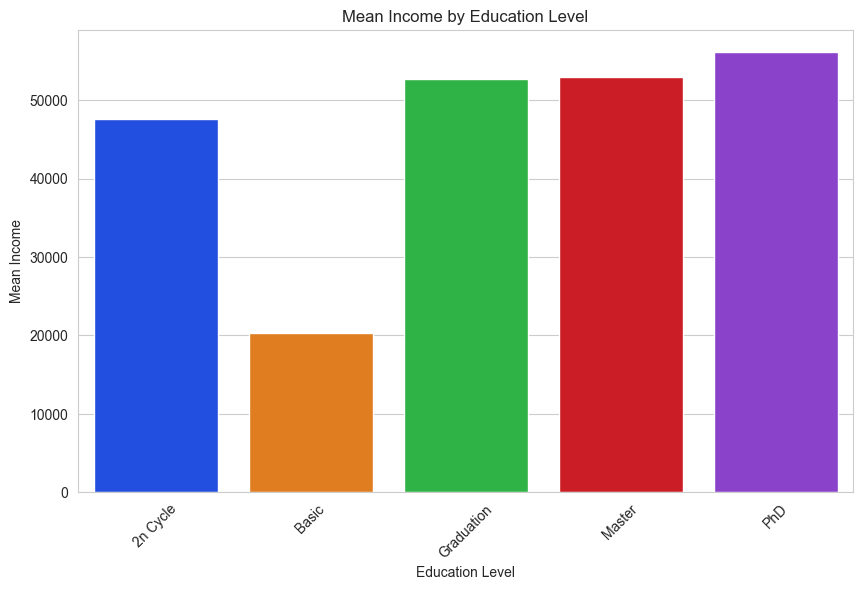

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='education', y='income', data=mean_income_by_education)
plt.title('Mean Income by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Mean Income')
plt.xticks(rotation=45)
plt.show()

I will keep the rows with missing income data. Almost 90% of the missing values are Graduation, Master, and PhD. I'll use the mean of these segments to back fill the data.

In [18]:
mean_income_by_education = df.groupby('education')['income'].transform('mean')

In [19]:
df['income'].fillna(mean_income_by_education, inplace=True)

In [20]:
# Check for missing values
df.isna().sum()

id                     0
birth_year             0
education              0
marital_status         0
income                 0
kids_at_home           0
teens_at_home          0
date_customer          0
days_last_purchase     0
wines                  0
fruits                 0
meat                   0
fish                   0
sweets                 0
gold                   0
discount_purchases     0
web_purchases          0
catalog_purchases      0
store_purchases        0
web_visits             0
accepted_campaign_3    0
accepted_campaign_4    0
accepted_campaign_5    0
accepted_campaign_1    0
accepted_campaign_2    0
complaint              0
cost_contact           0
revenue                0
response               0
dtype: int64

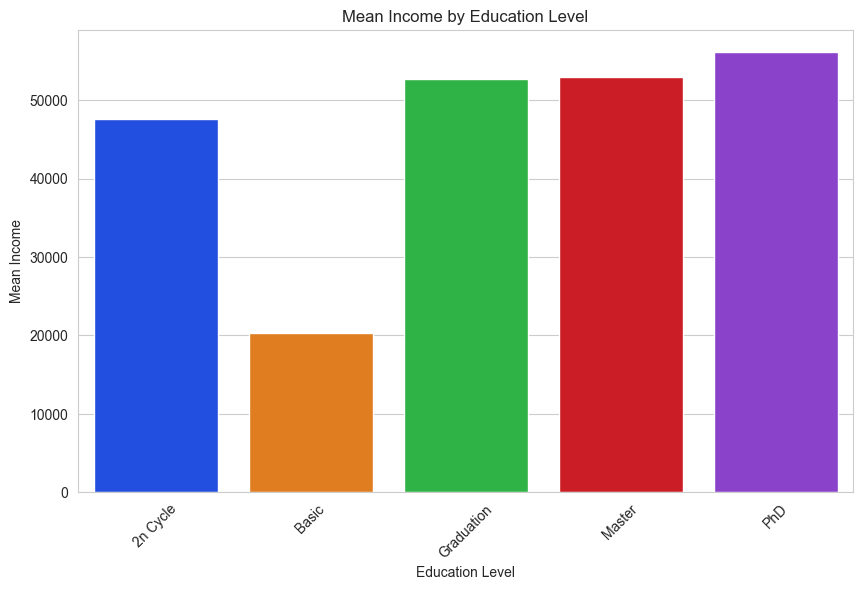

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x='education', y='income', data=df.groupby('education')['income'].mean().reset_index())
plt.title('Mean Income by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Mean Income')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

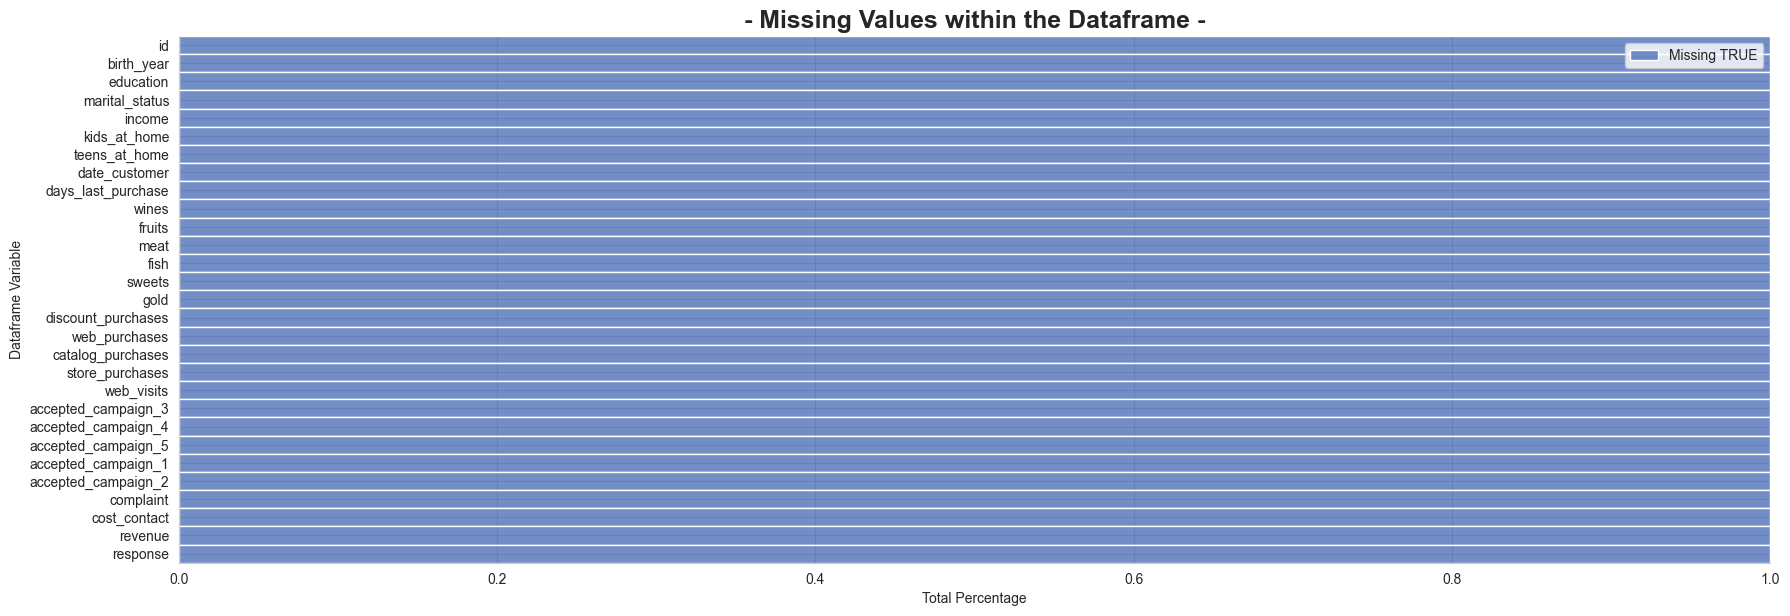

In [22]:
plt.figure(figsize=(10,6))

sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    
    # Change aspect of the chart
    aspect=3,
    height=6,
    
    # Change colors
    palette=[my_colors[5], my_colors[2]], 
    legend=False)

plt.title("- Missing Values within the Dataframe -", size=18, weight="bold")
plt.xlabel("Total Percentage")
plt.ylabel("Dataframe Variable")
plt.legend(["Missing TRUE", "Missing FALSE"]);

It looks like we now have a complete data set.

#### Fix data types

I will change the data types for the "money" columns to match income.

In [23]:
df = (
    df.rename(columns=new_column_names)
    .assign(date_customer=lambda df: pd.to_datetime(df["date_customer"], 
                                                    format="%Y-%m-%d"
                                                    ),
            education=lambda df: df["education"].str.lower(),
            marital_status=lambda df: df["marital_status"].str.lower(),
            wines=lambda df: df["wines"].astype("float"),
            fruits=lambda df: df["fruits"].astype("float"),
            meat=lambda df: df["meat"].astype("float"),
            fish=lambda df: df["fish"].astype("float"),
            sweets=lambda df: df["sweets"].astype("float"),
            gold=lambda df: df["gold"].astype("float"),
            )
)

In [24]:
df.head()

,id,birth_year,education,marital_status,income,kids_at_home,teens_at_home,date_customer,days_last_purchase,wines,fruits,meat,fish,sweets,gold,discount_purchases,web_purchases,catalog_purchases,store_purchases,web_visits,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complaint,cost_contact,revenue,response
0,5524,1957,graduation,single,58138.0,0,0,2012-09-04,58,635.0,88.0,546.0,172.0,88.0,88.0,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,graduation,single,46344.0,1,1,2014-03-08,38,11.0,1.0,6.0,2.0,1.0,6.0,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,graduation,together,71613.0,0,0,2013-08-21,26,426.0,49.0,127.0,111.0,21.0,42.0,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,graduation,together,26646.0,1,0,2014-02-10,26,11.0,4.0,20.0,10.0,3.0,5.0,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,phd,married,58293.0,1,0,2014-01-19,94,173.0,43.0,118.0,46.0,27.0,15.0,5,5,3,6,5,0,0,0,0,0,0,3,11,0


### Inspect and drop unnecessary columns

Most of the columns are self-explanatory. I checked the Kaggle discussion boards and someone asked the question if "gold" meant jewelry. This seems like a fair assumption, so we'll leave that column. Originally there were columns prefixed with Z. These were renamed to cost_contact and revenue. 

In [25]:
df["cost_contact"].value_counts()

cost_contact
3    2240
Name: count, dtype: int64

In [26]:
df["revenue"].value_counts()

revenue
11    2240
Name: count, dtype: int64

These two columns have repeat values with no meaning. We will drop them. We will also drop the ID column.

In [27]:
df = (
    df.rename(columns=new_column_names)
    .assign(date_customer=lambda df: pd.to_datetime(df["date_customer"], 
                                                    format="%Y-%m-%d"
                                                    ),
            education=lambda df: df["education"].str.lower(),
            marital_status=lambda df: df["marital_status"].str.lower(),
            wines=lambda df: df["wines"].astype("float"),
            fruits=lambda df: df["fruits"].astype("float"),
            meat=lambda df: df["meat"].astype("float"),
            fish=lambda df: df["fish"].astype("float"),
            sweets=lambda df: df["sweets"].astype("float"),
            gold=lambda df: df["gold"].astype("float"),
            )
)
df.drop(columns=["id", "cost_contact", "revenue"], inplace=True) # drop ID and the columns with constant values

In [28]:
df['education'].value_counts()

education
graduation    1127
phd            486
master         370
2n cycle       203
basic           54
Name: count, dtype: int64

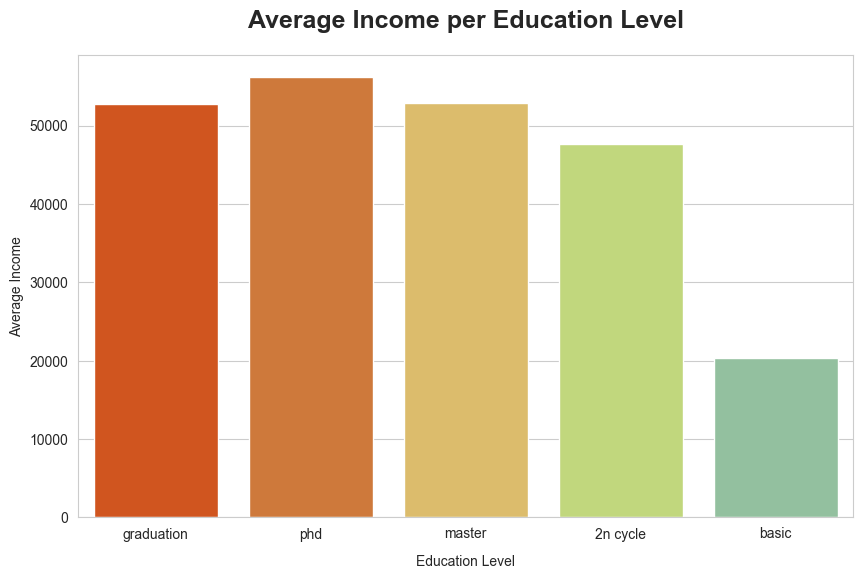

In [29]:
sorted_df = df.sort_values('income', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="education", y="income", data=sorted_df, ci=None, palette=my_colors)
plt.title("Average Income per Education Level", size=18, weight="bold", pad=20)
plt.xlabel("Education Level", labelpad=10)
plt.ylabel("Average Income");


I checked out some online resources and it appears 2n cycle, referred to as Second Cycle, is usually in reference to a Master's level program. There is no way to tell definitively if  Basic refers to High School Diploma, or something else, so we'll leave the data as is.

In [30]:
df['marital_status'].value_counts()

marital_status
married     864
together    580
single      480
divorced    232
widow        77
alone         3
absurd        2
yolo          2
Name: count, dtype: int64

In [31]:
# Look at rows where marital status is absurd or yolo

df.loc[df['marital_status'].isin(['absurd', 'yolo'])]

,birth_year,education,marital_status,income,kids_at_home,teens_at_home,date_customer,days_last_purchase,wines,fruits,meat,fish,sweets,gold,discount_purchases,web_purchases,catalog_purchases,store_purchases,web_visits,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complaint,response
2093,1993,graduation,absurd,79244.0,0,0,2012-12-19,58,471.0,102.0,125.0,212.0,61.0,245.0,1,4,10,7,1,0,0,1,1,0,0,1
2134,1957,master,absurd,65487.0,0,0,2014-01-10,48,240.0,67.0,500.0,199.0,0.0,163.0,3,3,5,6,2,0,0,0,0,0,0,0
2177,1973,phd,yolo,48432.0,0,1,2012-10-18,3,322.0,3.0,50.0,4.0,3.0,42.0,5,7,1,6,8,0,0,0,0,0,0,0
2202,1973,phd,yolo,48432.0,0,1,2012-10-18,3,322.0,3.0,50.0,4.0,3.0,42.0,5,7,1,6,8,0,0,0,0,0,0,1


With only four rows, we could possibly create a column called "Relationship_Status" that's either Married or Not Married. Absurd and Yolo would be placed into Not Married.

We will encode the categorical values in a future step.

### Look for outliers

In [32]:
df.describe()

,birth_year,income,kids_at_home,teens_at_home,date_customer,days_last_purchase,wines,fruits,meat,fish,sweets,gold,discount_purchases,web_purchases,catalog_purchases,store_purchases,web_visits,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complaint,response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1968.805804,52253.592375,0.444196,0.506250,2013-07-10 10:01:42.857142784,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,0.149107
min,1893.000000,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,35538.750000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1970.000000,51609.500000,0.000000,0.000000,2013-07-08 12:00:00,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1977.000000,68289.750000,1.000000,1.000000,2013-12-30 06:00:00,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1996.000000,666666.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,11.984069,25039.085601,0.538398,0.544538,NaN,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.356274


The max of 666,666 under income jumps out as a potential outlier. Also, the minimum birth year of 1893 looks suspicious.

In [33]:
# Find birth years that are not possible
df.loc[(df['birth_year'] < 1930)]

,birth_year,education,marital_status,income,kids_at_home,teens_at_home,date_customer,days_last_purchase,wines,fruits,meat,fish,sweets,gold,discount_purchases,web_purchases,catalog_purchases,store_purchases,web_visits,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complaint,response
192,1900,2n cycle,divorced,36640.0,1,0,2013-09-26,99,15.0,6.0,8.0,7.0,4.0,25.0,1,2,1,2,5,0,0,0,0,0,1,0
239,1893,2n cycle,single,60182.0,0,1,2014-05-17,23,8.0,0.0,5.0,7.0,0.0,2.0,1,1,0,2,4,0,0,0,0,0,0,0
339,1899,phd,together,83532.0,0,0,2013-09-26,36,755.0,144.0,562.0,104.0,64.0,224.0,1,4,6,4,1,0,0,1,0,0,0,0


Yep. This looks wrong. We will drop these rows. Now I'll look at income.

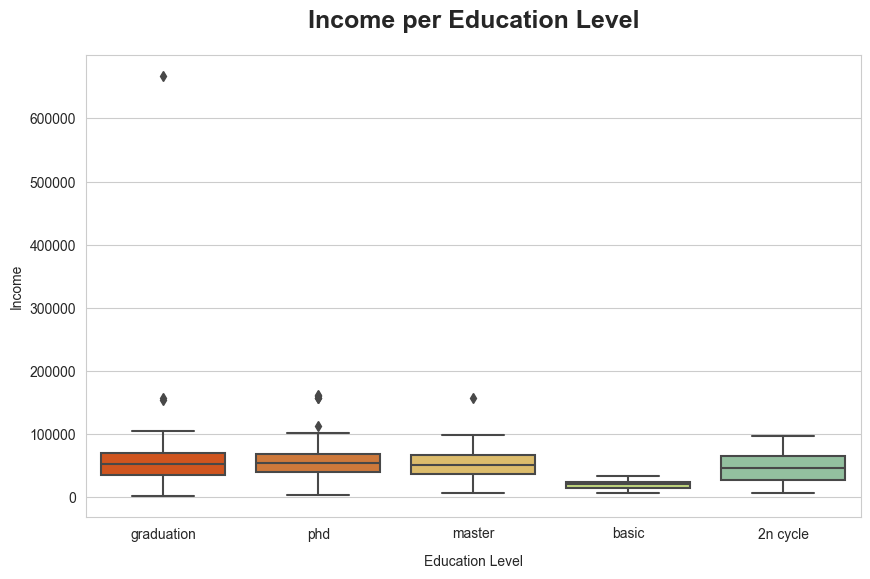

In [34]:
plt.figure(figsize=(10,6))
sns.boxplot(x="education", y="income", data=df, palette=my_colors)
plt.title("Income per Education Level", size=18, weight="bold", pad=20)
plt.xlabel("Education Level", labelpad=10)
plt.ylabel("Income");

We will drop the extreme outlier in income: $666,666. The others appear to be OK within the upperbounds of the IQR.

In [35]:
# Drop the outlier 666666 income
df = (
    df.rename(columns=new_column_names)
    .assign(date_customer=lambda df: pd.to_datetime(df["date_customer"], 
                                                    format="%Y-%m-%d"
                                                    ),
            education=lambda df: df["education"].str.lower(),
            marital_status=lambda df: df["marital_status"].str.lower(),
            wines=lambda df: df["wines"].astype("float"),
            fruits=lambda df: df["fruits"].astype("float"),
            meat=lambda df: df["meat"].astype("float"),
            fish=lambda df: df["fish"].astype("float"),
            sweets=lambda df: df["sweets"].astype("float"),
            gold=lambda df: df["gold"].astype("float"),
            )
)
#df.drop(columns=["id", "cost_contact", "revenue"], inplace=True) # drop ID and the columns with constant values
df = df[df['income'] != 666666] # drop the outlier for income
df = df[df['birth_year'] > 1930] # drop the outlier for birth year

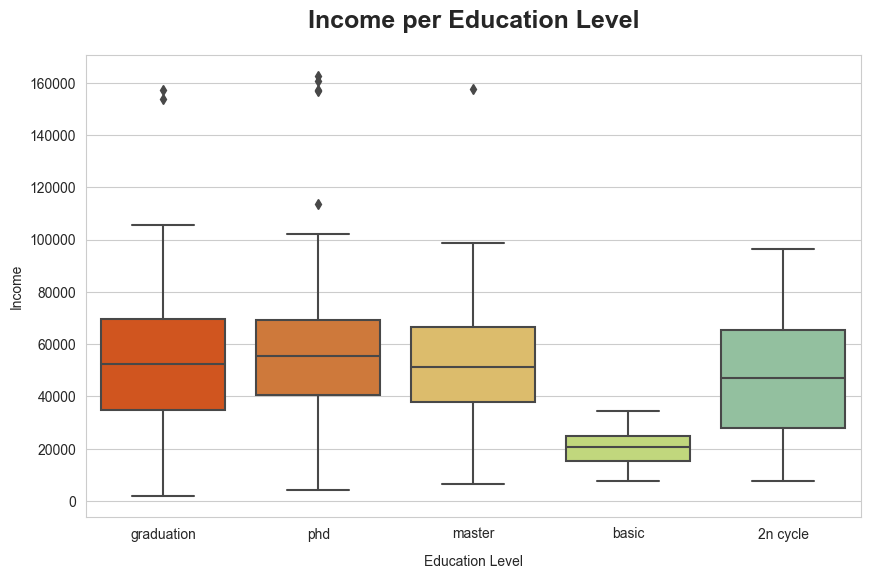

In [36]:
plt.figure(figsize=(10,6))
sns.boxplot(x="education", y="income", data=df, palette=my_colors)
plt.title("Income per Education Level", size=18, weight="bold", pad=20)
plt.xlabel("Education Level", labelpad=10)
plt.ylabel("Income");

### Feature engineering

In [37]:
df['marital_status'].value_counts()

marital_status
married     864
together    578
single      479
divorced    231
widow        77
alone         3
absurd        2
yolo          2
Name: count, dtype: int64

In [38]:
# Create a relationship_status column based on the marital_status column
def relationship_status(status):
    if status in ['single', 'divorced', 'widow', 'alone', 'absurd', 'yolo']:
        return 'no'
    else:
        return 'yes'

In [39]:
# Create the relationship_status column
df['relationship_status'] = df['marital_status'].apply(relationship_status)

In [40]:
df.head()

,birth_year,education,marital_status,income,kids_at_home,teens_at_home,date_customer,days_last_purchase,wines,fruits,meat,fish,sweets,gold,discount_purchases,web_purchases,catalog_purchases,store_purchases,web_visits,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complaint,response,relationship_status
0,1957,graduation,single,58138.0,0,0,2012-09-04,58,635.0,88.0,546.0,172.0,88.0,88.0,3,8,10,4,7,0,0,0,0,0,0,1,no
1,1954,graduation,single,46344.0,1,1,2014-03-08,38,11.0,1.0,6.0,2.0,1.0,6.0,2,1,1,2,5,0,0,0,0,0,0,0,no
2,1965,graduation,together,71613.0,0,0,2013-08-21,26,426.0,49.0,127.0,111.0,21.0,42.0,1,8,2,10,4,0,0,0,0,0,0,0,yes
3,1984,graduation,together,26646.0,1,0,2014-02-10,26,11.0,4.0,20.0,10.0,3.0,5.0,2,2,0,4,6,0,0,0,0,0,0,0,yes
4,1981,phd,married,58293.0,1,0,2014-01-19,94,173.0,43.0,118.0,46.0,27.0,15.0,5,5,3,6,5,0,0,0,0,0,0,0,yes


We will create some new features that may help us with model prediction. 

1. Total amount purchased (Add Wines, Fruits, Meat, Fish, Sweets, Gold).
2. Total items purchased (Add Web, Catalog, Store). We will not add Discount as it isn't clear where the discount occurred.
3. Total accepted campaigns (Add all Accepted Campaigns).
4. Total childeren (Add kids and teens at home).
5. Age of the customer.
6. How long has the person been a customer.

In [42]:
# Drop the outlier 666666 income
df = (
    df.rename(columns=new_column_names)
    .assign(date_customer=lambda df: pd.to_datetime(df["date_customer"], 
                                                    format="%Y-%m-%d"
                                                    ),
            education=lambda df: df["education"].str.lower(),
            marital_status=lambda df: df["marital_status"].str.lower(),
            wines=lambda df: df["wines"].astype("float"),
            fruits=lambda df: df["fruits"].astype("float"),
            meat=lambda df: df["meat"].astype("float"),
            fish=lambda df: df["fish"].astype("float"),
            sweets=lambda df: df["sweets"].astype("float"),
            gold=lambda df: df["gold"].astype("float"),
            )
)
#df.drop(columns=["id", "cost_contact", "revenue"], inplace=True) # drop ID and the columns with constant values
df = df[df['income'] != 666666] # drop the outlier
df = df[df['birth_year'] > 1930] # drop the outlier

# Feature engineering

# Create a new column that adds wines, fruits, meat, fish, sweets, and gold
df['total_spent'] = df['wines'] + df['fruits'] + df['meat'] + df['fish'] + df['sweets'] + df['gold']

# Create a new column that adds the number of purchases
df['total_purchases'] = df['discount_purchases'] + df['web_purchases'] + df['catalog_purchases'] + df['store_purchases']

# Create a new column that adds the total number of accepted offers
df['total_accepted_offers'] = df['accepted_campaign_3'] + df['accepted_campaign_4'] + df['accepted_campaign_5'] + df['accepted_campaign_1'] + df['accepted_campaign_2']

# Create a new column that adds the total number of children
df['total_children'] = df['kids_at_home'] + df['teens_at_home']

# Create a new column that calculates the age of the customer
df['age'] = 2024 - df['birth_year']

# Create a new column that calculates how long the person has been a customer
df['days_customer'] = (pd.to_datetime('2024-01-01') - df['date_customer']).dt.days


In [43]:
df.head()

,birth_year,education,marital_status,income,kids_at_home,teens_at_home,date_customer,days_last_purchase,wines,fruits,meat,fish,sweets,gold,discount_purchases,web_purchases,catalog_purchases,store_purchases,web_visits,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complaint,response,relationship_status,total_spent,total_purchases,total_accepted_offers,total_children,age,days_customer
0,1957,graduation,single,58138.0,0,0,2012-09-04,58,635.0,88.0,546.0,172.0,88.0,88.0,3,8,10,4,7,0,0,0,0,0,0,1,no,1617.0,25,0,0,67,4136
1,1954,graduation,single,46344.0,1,1,2014-03-08,38,11.0,1.0,6.0,2.0,1.0,6.0,2,1,1,2,5,0,0,0,0,0,0,0,no,27.0,6,0,2,70,3586
2,1965,graduation,together,71613.0,0,0,2013-08-21,26,426.0,49.0,127.0,111.0,21.0,42.0,1,8,2,10,4,0,0,0,0,0,0,0,yes,776.0,21,0,0,59,3785
3,1984,graduation,together,26646.0,1,0,2014-02-10,26,11.0,4.0,20.0,10.0,3.0,5.0,2,2,0,4,6,0,0,0,0,0,0,0,yes,53.0,8,0,1,40,3612
4,1981,phd,married,58293.0,1,0,2014-01-19,94,173.0,43.0,118.0,46.0,27.0,15.0,5,5,3,6,5,0,0,0,0,0,0,0,yes,422.0,19,0,1,43,3634


### Encode categorical variables

In [44]:
# Count the unique values in Education

df.education.value_counts()

education
graduation    1126
phd            485
master         370
2n cycle       201
basic           54
Name: count, dtype: int64

In [45]:
# Instantiate the label encoder
label_encoder = LabelEncoder()

In [46]:
# Education column
label_encoder.fit(df['education'])
df['education'] = label_encoder.transform(df['education'])

In [47]:
# Check the education mappings
education_mappings = {index: label for index, label in enumerate(label_encoder.classes_)}
print(education_mappings)

{0: '2n cycle', 1: 'basic', 2: 'graduation', 3: 'master', 4: 'phd'}


In [48]:
# Marital_Status
df.marital_status.value_counts()

marital_status
married     864
together    578
single      479
divorced    231
widow        77
alone         3
absurd        2
yolo          2
Name: count, dtype: int64

In [49]:
label_encoder.fit(df['marital_status'])
df['marital_status'] = label_encoder.transform(df['marital_status'])

In [50]:
relationship_mappings = {index: label for index, label in enumerate(label_encoder.classes_)}
print(relationship_mappings)

{0: 'absurd', 1: 'alone', 2: 'divorced', 3: 'married', 4: 'single', 5: 'together', 6: 'widow', 7: 'yolo'}


In [51]:
# Encode the relationship_status column
label_encoder.fit(df['relationship_status'])
df['relationship_status'] = label_encoder.transform(df['relationship_status'])

In [52]:
relationship_status_mappings = {index: label for index, label in enumerate(label_encoder.classes_)}
print(relationship_status_mappings)

{0: 'no', 1: 'yes'}


In [53]:
df.head()

,birth_year,education,marital_status,income,kids_at_home,teens_at_home,date_customer,days_last_purchase,wines,fruits,meat,fish,sweets,gold,discount_purchases,web_purchases,catalog_purchases,store_purchases,web_visits,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complaint,response,relationship_status,total_spent,total_purchases,total_accepted_offers,total_children,age,days_customer
0,1957,2,4,58138.0,0,0,2012-09-04,58,635.0,88.0,546.0,172.0,88.0,88.0,3,8,10,4,7,0,0,0,0,0,0,1,0,1617.0,25,0,0,67,4136
1,1954,2,4,46344.0,1,1,2014-03-08,38,11.0,1.0,6.0,2.0,1.0,6.0,2,1,1,2,5,0,0,0,0,0,0,0,0,27.0,6,0,2,70,3586
2,1965,2,5,71613.0,0,0,2013-08-21,26,426.0,49.0,127.0,111.0,21.0,42.0,1,8,2,10,4,0,0,0,0,0,0,0,1,776.0,21,0,0,59,3785
3,1984,2,5,26646.0,1,0,2014-02-10,26,11.0,4.0,20.0,10.0,3.0,5.0,2,2,0,4,6,0,0,0,0,0,0,0,1,53.0,8,0,1,40,3612
4,1981,4,3,58293.0,1,0,2014-01-19,94,173.0,43.0,118.0,46.0,27.0,15.0,5,5,3,6,5,0,0,0,0,0,0,0,1,422.0,19,0,1,43,3634


### Log assets to W&B

I will log the feature mappings into W&B so I can reference it in the future.

In [54]:
run = wandb.init(project='marketing-analytics', name='categorical_encodings', config=CONFIG)
wandb.config.update({'education_mappings': education_mappings, 'relationship_mappings': relationship_mappings, 
                     'relationship_status_mappings': relationship_status_mappings})
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


I will also log the clean, transformed dataset now that I've finished data preprocessing.

In [55]:
# Export the cleaned dataset
df.to_csv('data/marketing_campaign_cleaned.csv', index=False)

In [56]:
# Log the clean dataset into W&B Artifactory
CLEAN_PATH = 'data/marketing_campaign_cleaned.csv'

save_dataset_artifact(run_name='clean_dataset_artifact', 
                      artifact_name='clean_dataset_marketing_campaign', 
                      path=CLEAN_PATH)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Artifact has been saved successfully.


### EDA and visualizations

I'll start EDA by diving into some of the individual features before stepping into bivariate and multivariate analysis.

In [59]:
df.head()

,birth_year,education,marital_status,income,kids_at_home,teens_at_home,date_customer,days_last_purchase,wines,fruits,meat,fish,sweets,gold,discount_purchases,web_purchases,catalog_purchases,store_purchases,web_visits,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complaint,response,relationship_status,total_spent,total_purchases,total_accepted_offers,total_children,age,days_customer
0,1957,2,4,58138.0,0,0,2012-09-04,58,635.0,88.0,546.0,172.0,88.0,88.0,3,8,10,4,7,0,0,0,0,0,0,1,0,1617.0,25,0,0,67,4136
1,1954,2,4,46344.0,1,1,2014-03-08,38,11.0,1.0,6.0,2.0,1.0,6.0,2,1,1,2,5,0,0,0,0,0,0,0,0,27.0,6,0,2,70,3586
2,1965,2,5,71613.0,0,0,2013-08-21,26,426.0,49.0,127.0,111.0,21.0,42.0,1,8,2,10,4,0,0,0,0,0,0,0,1,776.0,21,0,0,59,3785
3,1984,2,5,26646.0,1,0,2014-02-10,26,11.0,4.0,20.0,10.0,3.0,5.0,2,2,0,4,6,0,0,0,0,0,0,0,1,53.0,8,0,1,40,3612
4,1981,4,3,58293.0,1,0,2014-01-19,94,173.0,43.0,118.0,46.0,27.0,15.0,5,5,3,6,5,0,0,0,0,0,0,0,1,422.0,19,0,1,43,3634


Text(0.5, 1.0, "Distribution of Customer's Age")

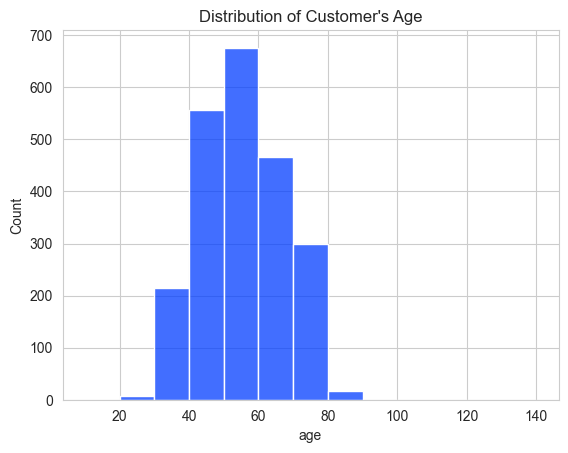

In [57]:
sns.histplot(data=df, x="age", bins = list(range(10, 150, 10)))
plt.title("Distribution of Customer's Age")

Most customers are between 40-60 years of age.

I'll look at the relationship betwee income and total amount spent.

In [60]:
fig = px.scatter(data_frame=df, x="income",
                 y="total_spent",
                 title="Relationship Between Customer's Income and Total Amount Spent",
                height=500,
                color_discrete_sequence = px.colors.qualitative.G10[1:])
fig.show()

It appears that as income increase, so too does the total amount a customer spends.

In [61]:
fig = px.scatter(
    data_frame=df,
    x = "income",
    y= "total_spent",
    title = "Relationship between Income VS Total Amount Spent Based on Education",
    color = "education",
    height=500
)
fig.show()

Roughly speaking, median income of people who don't respond is 50K vs 65K for people who have responded. Not too bad of a gap, but income does appear to be a driver for whether a person responds to a campaign.

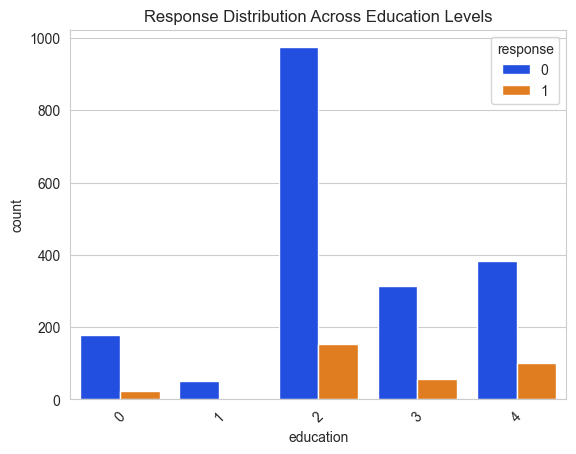

In [63]:
sns.countplot(x='education', hue='response', data=df)
plt.title('Response Distribution Across Education Levels')
plt.xticks(rotation=45)
plt.show()

Graduation and above appear most likely to repsond.

In [66]:
(df
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
).set_sticky(axis='index')

,birth_year,education,marital_status,income,kids_at_home,teens_at_home,date_customer,days_last_purchase,wines,fruits,meat,fish,sweets,gold,discount_purchases,web_purchases,catalog_purchases,store_purchases,web_visits,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complaint,response,relationship_status,total_spent,total_purchases,total_accepted_offers,total_children,age,days_customer
birth_year,1.000000,-0.184966,-0.044853,-0.216630,0.259291,-0.386963,-0.015666,-0.020109,-0.235299,-0.025623,-0.113693,-0.030081,0.002990,-0.076444,-0.089713,-0.166322,-0.179491,-0.170470,0.129426,0.063694,-0.067430,0.017367,-0.006731,-0.013720,-0.000828,0.019953,0.006723,-0.157677,-0.187581,-0.022819,-0.087861,-1.000000,0.015666
education,-0.184966,1.000000,0.001400,0.141801,-0.050613,0.118818,0.058367,-0.016470,0.229241,-0.162495,0.062561,-0.165298,-0.166976,-0.136283,0.025262,0.090123,0.085297,0.084419,-0.053310,0.005095,0.053559,0.028407,-0.013771,0.018321,-0.043575,0.092808,-0.011120,0.094189,0.095539,0.036921,0.051809,0.184966,-0.058367
marital_status,-0.044853,0.001400,1.000000,0.002996,-0.014932,-0.011354,-0.011456,0.018949,0.012275,0.002940,0.024012,0.026066,0.014051,0.016987,-0.035059,-0.006466,0.021938,-0.002870,-0.033876,-0.024915,0.011108,0.011048,-0.015302,0.019196,0.003706,-0.008423,0.067693,0.017503,-0.002974,-0.003358,-0.023686,0.044853,0.011456
income,-0.216630,0.141801,0.002996,1.000000,-0.557769,0.046956,0.022557,0.009801,0.829470,0.579397,0.814589,0.574645,0.565529,0.504202,-0.194214,0.572038,0.789570,0.731505,-0.640411,-0.015032,0.221967,0.393015,0.328498,0.105151,-0.027839,0.160730,-0.007886,0.849159,0.711661,0.339644,-0.373376,0.216630,-0.022557
kids_at_home,0.259291,-0.050613,-0.014932,-0.557769,1.000000,-0.045464,0.049292,0.005344,-0.580596,-0.450747,-0.551003,-0.452685,-0.439045,-0.426895,0.260163,-0.422342,-0.598110,-0.557241,0.481562,0.020404,-0.164339,-0.210213,-0.180309,-0.083750,0.035435,-0.077443,0.022881,-0.615552,-0.496434,-0.213972,0.673254,-0.259291,-0.049292
teens_at_home,-0.386963,0.118818,-0.011354,0.046956,-0.045464,1.000000,-0.019649,0.010440,0.111588,-0.200168,-0.127475,-0.229367,-0.197746,-0.021661,0.481933,0.146637,-0.043194,0.076976,0.111288,-0.045593,0.037227,-0.199252,-0.145520,-0.017702,0.005474,-0.159818,0.031797,-0.056232,0.130520,-0.113587,0.698639,0.386963,0.019649
date_customer,-0.015666,0.058367,-0.011456,0.022557,0.049292,-0.019649,1.000000,-0.024391,-0.153762,-0.127393,-0.155500,-0.131451,-0.115825,-0.225050,-0.215564,-0.199864,-0.123946,-0.112336,-0.301119,0.007733,-0.018158,0.005748,0.040128,-0.006221,-0.035967,-0.194462,0.007475,-0.183894,-0.196249,0.012273,0.022790,0.015666,-1.000000
days_last_purchase,-0.020109,-0.016470,0.018949,0.009801,0.005344,0.010440,-0.024391,1.000000,0.018714,0.025407,0.028221,0.013622,0.023857,0.017852,0.008376,-0.003967,0.030634,0.005609,-0.022259,-0.032815,0.018780,0.001369,-0.019335,-0.001927,0.005405,-0.198457,-0.003568,0.019979,0.009899,-0.014727,0.011977,0.020109,0.024391
wines,-0.235299,0.229241,0.012275,0.829470,-0.580596,0.111588,-0.153762,0.018714,1.000000,0.517224,0.823268,0.524414,0.504564,0.574714,0.057465,0.740155,0.823393,0.807084,-0.389359,0.034503,0.310875,0.364844,0.304281,0.138273,-0.034095,0.198932,-0.005401,0.926965,0.842365,0.405648,-0.334958,0.235299,0.153762
fruits,-0.025623,-0.162495,0.002940,0.579397,-0.450747,-0.200168,-0.127393,0.025407,0.517224,1.000000,0.712998,0.704886,0.691183,0.567899,-0.110158,0.470904,0.634198,0.583955,-0.442861,0.009228,0.030472,0.235132,0.177982,0.002767,-0.011448,0.149144,-0.034972,0.682015,0.573728,0.150749,-0.467641,0.025623,0.127393


Based on the Spearman correlation coefficient of features, the most significant feature is total_accepted_offers, followed by accepted_campaign_5, accepted_campaign_1 and accepted_campaign_3.

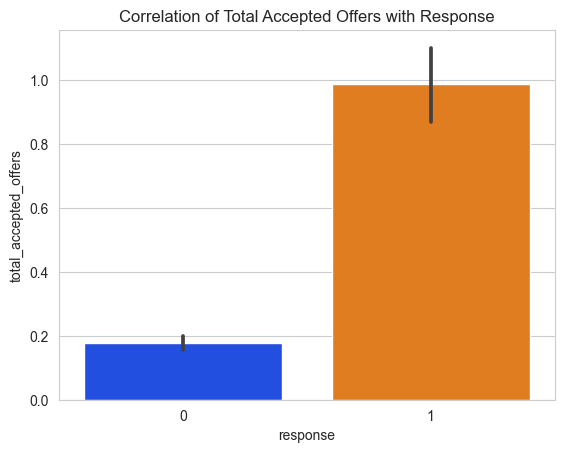

In [67]:
# Create a bar plot showing the correlation of total_accepted_offers with the response
sns.barplot(x='response', y='total_accepted_offers', data=df)
plt.title('Correlation of Total Accepted Offers with Response')
plt.show()

<Axes: xlabel='total_accepted_offers'>

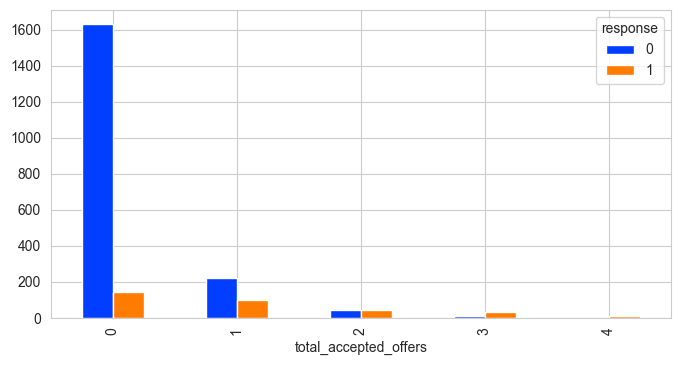

In [70]:
fig, ax = plt.subplots(figsize=(8, 4))
(df
 .groupby('total_accepted_offers')
 .response
 .value_counts()
 .unstack()
 .plot.bar(ax=ax)
)

### Customer segmentation

Let's try some clustering to see if we can see anymore patterns in the data that may help with our model approach. 

In [ ]:
# Work with scaled data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_filtered.drop(['ID', 'Dt_Customer', 'Response'], axis=1))


In [ ]:
# determin the number of K
from kneed import KneeLocator
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

k1 = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
optimized_k = k1.elbow

# visualize the result
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.vlines(optimized_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means clustering')
plt.show()

It looks like the optimal number of customer segments is 3. 

In [ ]:
# K-means clustering
kmeans = KMeans(n_clusters=optimized_k, random_state=42)
kmeans.fit(scaled_df)
labels = kmeans.labels_
df_filtered['Cluster'] = labels

In [ ]:
# Let's dig a little deeper into segmentation
fig, ax = plt.subplots(figsize=(10, 7))  
legend = []
x_label='Year_Birth'
y_label='Income'
ax.set_xlabel(x_label)             
ax.set_ylabel(y_label)  
plt.title('Customer Segmentation by Income and Birth Year')
for c, rows in df_filtered.groupby('Cluster'):
    plt.scatter(rows[x_label], rows[y_label], s = 100)
    legend.append("Cluster %s" % c)
plt.legend(legend, loc="upper left")
plt.grid()
plt.show()

In [ ]:
# How many customers are in each cluster?
df_filtered.groupby('Cluster')['ID'].count()

In [ ]:
# Mean Income by Cluster
df_filtered.groupby('Cluster')['Income'].mean()

Let's create a couple of more features for fun.

In [ ]:
# Check that the outliers have been removed
fig, ax = plt.subplots(figsize=(10, 7))  
legend = []
x_label='Year_Birth'
y_label='Income'
ax.set_xlabel(x_label)             
ax.set_ylabel(y_label)  
plt.title('Customer Segmentation by Income and Birth Year')
for c, rows in df_filtered.groupby('Cluster'):
    plt.scatter(rows[x_label], rows[y_label], s = 100)
    legend.append("Cluster %s" % c)
plt.legend(legend, loc="upper left")
plt.grid()
plt.show()

There have been quite a few updates to the dataset. Let's save the latest version and log to W&B. 

### Check target variable

In [ ]:
# Look at the distribution of the target variable
sns.countplot(x='response', data=df, palette=my_colors)
plt.title('Distribution of Target Variable (Response)')
plt.show()

The dataset is heavily imbalanced. We run the risk of the model becoming biased toward the majority class, in this case negative responses. There are a couple of options to explore:

1. Use the XGBoost built-in parameter ``scale_pos_weight`` which helps in handling imbalanced datasets. The parameter is used to give more weight to the minority class and balance the target variable. Reference article: https://forecastegy.com/posts/xgboost-imbalanced-data-scale_pos_weight-python/
2. Use SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class. This technique increases the number of instances of the minority class (in this case, Yes) by duplicating them or generating synthetic samples. Reference article: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 

### Decision Tree

We'll start with a simple decision tree model to get warmed up.

In [ ]:
# Start a W&B run
run = wandb.init(
    project='marketing-analytics', 
    config=CONFIG, 
    notes="Decision Tree Baseline", 
    tags=["baseline", "decision-tree"]
)

In [ ]:
# Create a dictionary of hyperparameters that can be used in a Decision Tree Classifier
config = wandb.config

# Hyperparameters
config.max_depth = 3
config.min_samples_split = 2
config.min_samples_leaf = 1
config.criterion = 'gini'
config.max_features = None
config.random_state = 42

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree

# Create the X and y variables
X = df_filtered.drop('Response', axis=1)
y = df_filtered['Response']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.random_state, test_size=0.2, stratify=y)

# Create the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=config.max_depth, 
                             min_samples_split=config.min_samples_split, 
                             min_samples_leaf=config.min_samples_leaf, 
                             criterion=config.criterion, 
                             max_features=config.max_features, 
                             random_state=config.random_state)

# Fit the model to the training data
clf.fit(X_train, y_train)

In [ ]:
# Log predictions on the test set into W&B
y_pred = clf.predict(X_test)
wandb.log({"y_pred": y_pred})


In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
# Log the accuracy to W&B
wandb.log({"accuracy": accuracy})

The overall accuracy is 85%. This is for both classes. Not the greatest, but that is to be expected because our data is highly imbalanced. The problem is improving the accuracy on the positive classes (class 1), where a customer has engaged with a campaign. The low F-1 score indicates that the model is not performing well in predicting class 1, which is no suprise because of the lower amount of samples in our data.

In [ ]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=['No', 'Yes'], rounded=True)
plt.show()

In [ ]:
# Finish the W&B run
wandb.finish()

### Random Forest

I'm going to try SMOTE on a Random Forest Classifier. I'll be looking to improve on the low F1 score for the positive class.

In [ ]:
df_smote = df_filtered.copy()

In [ ]:
X_smote = df_smote.drop('Response', axis=1)
y_smote = df_smote['Response']

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Split the data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, random_state=42, test_size=0.2, stratify=y_smote)

In [ ]:
# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_smote, y_train_smote)

In [ ]:
# Create the Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

In [ ]:
# Fit the model to the training data
rf_clf.fit(X_train_smote, y_train_smote)

In [ ]:
# Evaluate the model on the test data
y_pred_smote = rf_clf.predict(X_test_smote)

# Print classification report and confusion matrix
print(classification_report(y_test_smote, y_pred_smote))
print(confusion_matrix(y_test_smote, y_pred_smote))

Some improvement on the F1 Score for our positive class, and maybe with some more tuning we could see increased performance. But we'll move onto XGB and see what we can do there.

### XGBoost

In [ ]:
# Start a run
run = wandb.init(project='marketing-analytics', job_type="train-model", notes="XGBoost Baseline")

In [ ]:
# Set up and log model hyperparameters
early_stopping_rounds = 40

bst_params = {
    "objective": "binary:logistic",
    "base_score": 0.5,
    "gamma": 1,  ## def: 0
    "learning_rate": 0.1,  ## def: 0.1
    "max_depth": 3,
    "min_child_weight": 100,  ## def: 1
    "n_estimators": 25,
    "nthread": 24,
    "random_state": 42,
    "reg_alpha": 0,
    "reg_lambda": 0,  ## def: 1
    "eval_metric": ["auc", "logloss"],
    "tree_method": "hist",  # use `gpu_hist` to train on GPU
}

In [ ]:
# Log the parameters to W&B
run.config.update(dict(bst_params))
run.config.update({"early_stopping_rounds": early_stopping_rounds})

In [ ]:
# Build the XGBoost model using df_filtered
X = df_filtered.drop('Response', axis=1)
y = df_filtered['Response']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [ ]:
# Create the DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# Train the model
bst = xgb.train(bst_params, dtrain, evals=[(dtest, "test")], early_stopping_rounds=early_stopping_rounds)

In [ ]:
# Let's try this 
from xgboost import XGBClassifier

# Create the XGBClassifier
scale_pos_weight = len([label for label in y_train if label == 0]) / len([label for label in y_train if label == 1])


In [ ]:
# Initialize the XGBoost model
model = XGBClassifier(scale_pos_weight=scale_pos_weight, bst_params=bst_params)

In [ ]:
# Fit the model
model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [ ]:
wandb.finish()

### XGBoost Part 2 - Out of the Box (OOB)

In [ ]:
df_filtered.head()

In [ ]:
# Create an out of the box XGBoost classifier
xg_oob = XGBClassifier()
xg_oob.fit(X_train, y_train)
xg_oob.score(X_test, y_test)

Add max_depth and n_estimator parameters. 

1. max_depth: the max depth of each tree in the model. Depth is the longest path from a root to a leaf. Increasing max_depth can help the model learn complex relationships in the data, but it can also lead to overfitting.
2. n_estimators: specifies the number of trees to build. Each tree in XGBoost is meant to correct the errors made by the previous trees. Similar to max_depth, increasing the number of estimators can improve the model's ability to fit the data, but it can also to overfitting, especially if the individual trees are already deep.

In [ ]:
xg_oob2 = XGBClassifier(max_depth=2, n_estimators=2)
xg_oob2.fit(X_train, y_train)
xg_oob2.score(X_test, y_test)

A slight drop off. Let's use dtreeviz to inspect.

In [ ]:
import dtreeviz

In [ ]:
viz = dtreeviz.model(xg_oob2, X_train=X, y_train=y, 
               target_name='Response', 
               feature_names=list(X_train.columns), 
               class_names=['No', 'Yes'], 
               tree_index=0)

In [ ]:
viz.view(depth_range_to_display=[0,2], scale=2.5)

Before we try cross-validation, we'll continue to dive deeper into other parameters.

In [ ]:
# Try XGBoost with early stopping
xg_es = XGBClassifier(early_stopping_rounds=20)
xg_es.fit(X_train, y_train,
       eval_set=[(X_train, y_train), 
                 (X_test, y_test)],
       )
xg_es.score(X_test, y_test)

In [ ]:
# What was the limit of the early stopping?
xg_es.best_iteration

Explore the score.

In [ ]:
results = xg_es.evals_result()

From Matt Harrison's Effective XGBoost book!

In [ ]:
# Plot the results
fix, ax = plt.subplots(figsize=(8,4)) 
ax = (pd.DataFrame({'training': results['validation_0']['logloss'],
                    'testing': results['validation_1']['logloss']}) # create a dataframe with the logloss values
  .assign(ntrees=lambda adf: range(1, len(adf)+1)) # add a column for the number of trees
  .set_index('ntrees') # make that column the index
  .plot(figsize=(5,4), ax=ax,
      title='eval_results with early_stopping')
)
ax.set_xlabel('ntrees')

In [ ]:
# Try a model with 15 trees. Do we get the same result as with early stopping?
xg15 = XGBClassifier(n_estimators=15)
xg15.fit(X_train, y_train,
         eval_set=[(X_train, y_train),
                     (X_test, y_test)]
            )
xg15.score(X_test, y_test)

Not quite exactly the same, but close. We still haven't gone back to the imbalanced data issue. 

In [ ]:
# Import Yellowbrick
import yellowbrick.model_selection as ms 
from yellowbrick import classifier

In [ ]:
# Let's try Yellowbrick
fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train, param_name='gamma',
    param_range=[0, .5, 1,5,10, 20, 30], n_jobs=-1, ax=ax)

It looks like Gamma is best around 20. 

In [ ]:
# Create a new XGBoost model using scaled_pos_weight
scale_pos_weight = len([label for label in y_train if label == 0]) / len([label for label in y_train if label == 1])

# Initialize the XGBoost model
xg_spw = XGBClassifier(scale_pos_weight=scale_pos_weight)

# Fit the model
xg_spw.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_spw.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


### Hyperopt

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from typing import Any, Dict, Union

In [ ]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]], X_train: pd.DataFrame, y_train: pd.Series,
                    X_test: pd.DataFrame, y_test: pd.Series,
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
            for k,val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds 
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                  (X_test, y_test)]
    model.fit(X_train, y_train,
    eval_set=evaluation, verbose=False)
    pred = model.predict(X_test)
    score = metric(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [ ]:
# Define the search space
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1), # tree 
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3), 
           'subsample': hp.uniform('subsample', 0.5, 1), # stochastic 
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1), 
           'reg_alpha': hp.uniform('reg_alpha', 0, 10),
           'reg_lambda': hp.uniform('reg_lambda', 1, 10),
           'gamma': hp.loguniform('gamma', -10, 10), # regularization 
           'learning_rate': hp.loguniform('learning_rate', -7, 0), # boosting 
           'random_state': 42
}

In [ ]:
trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, X_test, y_test),
            space=options,
            algo=tpe.suggest,
            max_evals=2_000,
            trials=trials)


In [ ]:
# Inspection of the best model
best_model = trials.best_trial['result']['model']
best_model

Store the best model parameters in a dictionary.

In [ ]:
best_params = best_model.get_params()
best_params


In [ ]:
best_params = {'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9705100197049035,
 'device': None,
 #'early_stopping_rounds': 50,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.0002778120817967341,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.5405865428987514,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 3.368346608335616,
 'monotone_constraints': None,
 'multi_strategy': None,
 #'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 1,
 'reg_lambda': 1.0150610613186282,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.776565739766952,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
xg_ex = xgb.XGBClassifier(**best_params, early_stopping_rounds=50,
                          n_estimators=500)
xg_ex.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ],
verbose=100
)

In [ ]:
# How does the model perform?
xg_ex.score(X_test, y_test)

In [ ]:
# Print the confusion matrix
y_pred = xg_ex.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


The F1 score of the positive labels has jumped to .62. That's the best score so far.

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
ax = sns.heatmap(cm/np.sum(cm), annot=True,  fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

In [ ]:
# What are some of the most important features?
plt.figure(figsize=(10,6))
plt.barh(X_train.columns, xg_ex.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Let's explore what Hyperopt is doing.

In [ ]:
from typing import Any, Dict, Sequence
def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
     """
    Convert a Trial object (sequence of trial dictionaries)
    to a Pandas DataFrame.
    Parameters
    ----------
    trial : List[Dict[str, Any]]
        A list of trial dictionaries.
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns for the loss, trial id, and
    """ 
     vals = []
     for t in trial:
          result = t['result']
          misc = t['misc']
          val = {k:(v[0] if isinstance(v, list) else v)
                 for k,v in misc['vals'].items()
                    }
          val['loss'] = result['loss']
          val['tid'] = t['tid']
          vals.append(val)
     return pd.DataFrame(vals)
     

In [ ]:
hyper2hr = trial2df(trials)

In [ ]:
hyper2hr.sort_values('loss', ascending=False).head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4)) 
sns.heatmap(hyper2hr.corr(method='spearman'), cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax )

#### New version of scale_pos_weight

In [ ]:
# Let's try with a new version of scale_pos_weight
positive_count = sum(y_train == 1)
negative_count = sum(y_train == 0)
scale_pos_weight = negative_count / positive_count

In [ ]:
updated_params = {'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9705100197049035,
 'device': None,
 #'early_stopping_rounds': 50,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.0002778120817967341,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.5405865428987514,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 3.368346608335616,
 'monotone_constraints': None,
 'multi_strategy': None,
 #'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 1,
 'reg_lambda': 1.0150610613186282,
 'sampling_method': None,
 'scale_pos_weight': scale_pos_weight,
 'subsample': 0.776565739766952,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
xg_up = xgb.XGBClassifier(**updated_params, early_stopping_rounds=50,
                          n_estimators=500)
xg_up.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ],
verbose=100
)

In [ ]:
# How does the model perform?
xg_up.score(X_test, y_test)

It looks like Hyperopt accounts for imbalanced data when developing the best hyperparameters. Adding scale_pos_weight after establishing the parameters did not improve the accuracy of the model.

### Evaluation visualizations

In [ ]:
# xg_ex vs xg_es
fig, ax = plt.subplots(figsize=(8, 8))
metrics.RocCurveDisplay.from_estimator(xg_ex, X_test, y_test, ax=ax, name='xg_ex')
metrics.RocCurveDisplay.from_estimator(xg_es, X_test, y_test, ax=ax, name='xg_es')